# Strategies to prevent overfitting in neural networks

In [72]:
import  itertools 
?itertools.islice
# [i for i  in ]

In [61]:
def f():
    f()
    return 4
f()

RecursionError: maximum recursion depth exceeded

In [53]:
try:
    [1,2,3][4]
except IndexError:
    print("indx")
except:
    print("ex")
else:
    print("else")
finally:
    print("clean")

indx
clean


In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve,auc

from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dense, GlobalMaxPooling1D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping

from collections import Counter
from wordcloud import WordCloud
from nltk import word_tokenize
from matplotlib import pyplot as plt
import nltk
import seaborn as sns
seed = 1337
try:
    tf.set_random_seed(seed)                    # set the random seed for reproducibility
except:
    tf.random.set_seed(seed)                     # NOTE: Newer version of tensorflow uses tf.random.set_seed
np.random.seed(1337)                         #       instead of tf.set_random_seed

C:\ProgramData\Anaconda3\envs\DS4A\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\envs\DS4A\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\envs\DS4A\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\envs\DS4A\lib\site-packages\tensorflow\python\frame

## Introduction

**Business Context.** You are a data scientist working for a machine learning consultancy. One of your clients wants to be able to classify text reviews automatically by the likely rating (on a 1 - 5 scale) that that person would give. However, they do not have sufficient data they generated on their own to do this, so you need to use an external, rich dataset as a basis on which to build your model and then translate it over.

**Business Problem.** Your task is to **build a neural networks-based model for classifying text reviews into likely ratings (on a 1 - 5 scale)**.

**Analytical Context.** We'll use the Amazon review dataset again and try to classify reviews into star ratings automatically. Instead of just positive and negative, we'll take on the harder challenge of predicting the *exact* star rating. The lowest score is 1 and the highest is 5.

Instead of trying to optimize by pre-processing the text, we'll do very basic tokenization and experiment with different neural network models, architectures, and hyperparameters to optimize the results. You'll start by building a simple dense neural network and try to get it to perform better using various techniques. Then you'll evaluate the results and diagnose where it tends to perform more poorly.

## Setting up and preparing the data

We'll mainly be using the `keras` module from TensorFlow, but we'll also use `pandas` to read the CSV file and `sklearn` for some helper functions. We'll be using only the "Text" and "Score" columns in the `Reviews.csv` file:

In [3]:
amazon_reviews = pd.read_csv('Reviews.csv', nrows=262084)
amazon_reviews.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


### Exercise 1:

Combine the first 1,000 of each of the 1-, 2-, 3-, 4-, and 5-star reviews in `amazon_reviews` into a single DataFrame (so you should have 5,000 observations in total). Split this DataFrame into training and test sets, with 80% of the data for the training set.

**Hint:** `keras` will expected your labels to start with 0, and not 1, so make sure to adjust the labels accordingly.

**Answer.**

In [4]:
dfs = []
for i in range(5):
    df = pd.DataFrame(amazon_reviews[amazon_reviews.Score == i+1][:1000]["Text"])
    df["Score"] = i
    dfs.append(df)

new_df = pd.concat(dfs)
new_df.shape

(5000, 2)

In [5]:
new_df["Score"].value_counts()

3    1000
2    1000
1    1000
4    1000
0    1000
Name: Score, dtype: int64

In [7]:
trainx,testx,trainy,testy = train_test_split(new_df["Text"],new_df["Score"],random_state=seed)

------------

## Tokenizing our texts

Keras comes with its own functions to preprocess text, including a [tokenizer](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer) (a mapping from each word in our corpus to a unique integer). Unlike the `CountVectorizer` from `sklearn`, which produces sparse matrices, `keras` often expects to work with sequences representing only the words that occur in a text. To prepare text before feeding it into a neural network, we usually:

1. Create a [tokenizer](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer).
2. [Create sequences](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer#texts_to_sequences) from our text (each text becomes a list of integers, based on the tokenizer mapping, instead of words)
3. [Pad or truncate](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences) each sequence to a fixed length (very short texts get `0`s added to them, while very long ones are truncated).

The tokenizer has a configurable word cap, so it will only consider the $n$ most common words in the corpus, ignoring very rare words.

### Exercise 2:

In this exercise, you will learn how to use the `tf.keras.preprocessing.text.Tokenizer` tool to carry out the preprocessing steps described above.

#### 2.1

Perform some exploratory analysis of the dataset to calculate the number of unique words in our corpus and the distribution of the number of words in each review of the training set. What is the 80th percentile of this distribution?

**Answer.**

In [20]:
allText = " ".join(new_df["Text"].str.replace("<br />","").str.replace("\'",""))


In [21]:
allText

'Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo". My cats have been happily eating Felidae Platinum for more than two years. I just got a new bag and the shape of the food is different. They tried the new food when I first put it in their bowls and now the bowls sit full and the kitties will not touch the food. Ive noticed similar reviews related to formula changes in the past. Unfortunately, I now need to find a new food that my cats will eat. The candy is just red , No flavor . Just  plan and chewy .  I would never buy them again This oatmeal is not good. Its mushy, soft, I dont like it. Quaker Oats is the way to go. Arrived in 6 days and were so stale i could not eat any of the 6 bags!! Buyer Beware Please! This sweetener is not for everybody.  Maltitol is an alcohol sugar and can be undigestible in the body.  You will know a short time after 

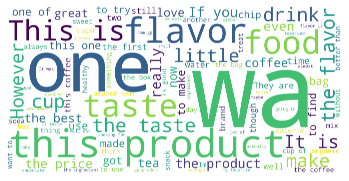

In [22]:
wc = WordCloud(background_color="white",width=800,height=400,scale=10,max_words=100).generate(allText)


plt.figure()
plt.imshow(wc,interpolation="bilinear")
plt.axis("off")
plt.show()

In [23]:
uniques = new_df["Text"].apply(lambda x: len(pd.Series(nltk.word_tokenize(x)).unique()))
print("Amount of unique words: ",sum(uniques))

Amount of unique words:  323575


In [24]:
lens = new_df["Text"].apply(lambda x: len(nltk.word_tokenize(x)))
print("Amount of words: ",sum(lens))

Amount of words:  505759


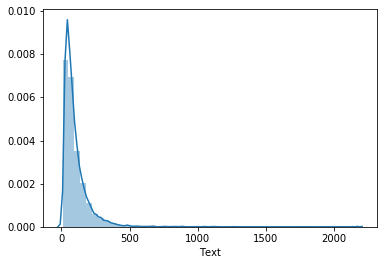

In [25]:
sns.distplot(lens)

In [31]:
lens.quantile(0.8)

141.0

Amount of words on training:  347523
80 quantile:  130.0


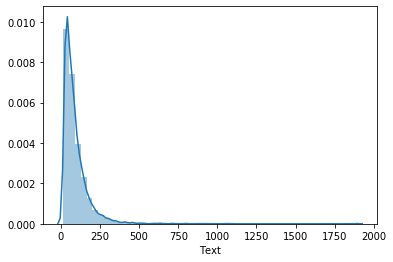

In [45]:
lens = trainx.apply(lambda x: len(nltk.word_tokenize(x.lower().replace("<br />","").replace("\'",""))))
print("Amount of words on training: ",sum(lens))
print("80 quantile: ",lens.quantile(0.8))
sns.distplot(lens)

------------

#### 2.2

Given the results above, we create a tokenizer using only the top 20,000 most frequent words in our corpus (which corresponds to roughly 80% of the words): 

In [33]:
tokenizer = Tokenizer(num_words=20000) #We create the tokenizer using only top 20000 words

In [34]:
trainx

2632    I was looking for an alternative green or whit...
1326    This powder, and this company, are both superb...
4626    These are ok. I like the sweet potato ones bet...
2736    This is  terrible popcorn! No taste, poor popp...
3672    Folks who are comparing this to Hodgson's blue...
                              ...                        
1877    I loved this product, and it was better than w...
4390    I ordered these despite my concerns after read...
9365    The coffee tasted bitter and like it was burnt...
2116    you won't BELIEVE how many ways this product h...
1718    Possibly THE best salt and vinegar chips (heal...
Name: Text, Length: 3750, dtype: object

In [35]:
tokenizer.fit_on_texts(trainx)  #Then, we create the text->indices mapping. 

The above line has given several features and methods to our tokenizer. For instance, print the line `tokenizer.word_index` in a new cell - what do you see? Apply the `tokenizer.texts_to_sequences()` method on the list `['I just feel very very good']`. Apply the `tokenizer.sequences_to_texts()` method on the list `[[109, 19, 824, 76, 114, 6315, 1137, 8070]]`. What were your results?

**Answer.**

------------

In [36]:
tokenizer.word_index

{'the': 1,
 'i': 2,
 'a': 3,
 'and': 4,
 'to': 5,
 'it': 6,
 'of': 7,
 'br': 8,
 'is': 9,
 'this': 10,
 'in': 11,
 'for': 12,
 'but': 13,
 'that': 14,
 'not': 15,
 'my': 16,
 'was': 17,
 'with': 18,
 'you': 19,
 'have': 20,
 'are': 21,
 'they': 22,
 'as': 23,
 'like': 24,
 'on': 25,
 'so': 26,
 'these': 27,
 'be': 28,
 'taste': 29,
 'if': 30,
 'good': 31,
 'coffee': 32,
 'them': 33,
 'product': 34,
 'or': 35,
 'just': 36,
 'all': 37,
 'at': 38,
 'one': 39,
 'very': 40,
 'flavor': 41,
 'would': 42,
 "it's": 43,
 'can': 44,
 'from': 45,
 'had': 46,
 'more': 47,
 'when': 48,
 'me': 49,
 'will': 50,
 'out': 51,
 'other': 52,
 'than': 53,
 'has': 54,
 'no': 55,
 'great': 56,
 'we': 57,
 'were': 58,
 'much': 59,
 'really': 60,
 'only': 61,
 'too': 62,
 "don't": 63,
 'some': 64,
 'chips': 65,
 'there': 66,
 'up': 67,
 'get': 68,
 'because': 69,
 'about': 70,
 'an': 71,
 'better': 72,
 'tea': 73,
 'sugar': 74,
 'amazon': 75,
 'what': 76,
 'your': 77,
 'which': 78,
 'buy': 79,
 'love': 80,
 'al

In [37]:

tokenizer.texts_to_sequences(['I just feel very very good'])

[[2, 36, 363, 40, 40, 31]]

In [38]:

tokenizer.sequences_to_texts([[109, 19, 824, 76, 114, 6315, 1137, 8070]])

['sweet you beef what now asleep locally sweetheart']

#### 2.3

Use the tokenizer to transform the texts in our test and train data to sequences. Then, use the `pad_sequences` function to pad/truncate these sequences to length 116 (the 80th percentile of text lengths). Save the resulting arrays as `train_sequences` and `test_sequences`.

**Answer.**

In [39]:

train_sequences = pad_sequences(tokenizer.texts_to_sequences(trainx),maxlen=116)
test_sequences = pad_sequences(tokenizer.texts_to_sequences(testx),maxlen=116)

------------

## Building a basic neural network model 

Now that we have preprocessed the text, let's create a basic neural network to train on our data. We'll use an embedding layer which performs [one-hot encoding](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/) on our word sequences, two fully connected ("dense") layers, and an output layer with 5 neurons to represent the 5 possible star ratings.

Before we train a `keras` model, there is an additional `compile` step where we define what loss function and optimizer to use, and what metrics to output. Then we can train the model using the `fit` function. All of this is shown below.

Note the `validation_split=0.2` argument which tells Keras to train on only 80% of the training data and tune the model on the remaining 20%, which we call the validation set. You can see the accuracy and loss for both the training and validation set in the output for each epoch:

In [40]:
model = Sequential()
model.add(Embedding(20000, 128, input_length=116))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(5, activation='sigmoid'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [41]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 116, 128)          2560000   
_________________________________________________________________
dense (Dense)                (None, 116, 128)          16512     
_________________________________________________________________
dense_1 (Dense)              (None, 116, 128)          16512     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 645       
Total params: 2,593,669
Trainable params: 2,593,669
Non-trainable params: 0
_________________________________________________________________


In [42]:
model.fit(train_sequences, trainy, validation_split=0.2, epochs=10)

Train on 3000 samples, validate on 750 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/10
3000/3000 [==============================] - 5s 2ms/sample - loss: 1.5890 - acc: 0.2877 - val_loss: 1.5339 - val_acc: 0.3107
Epoch 2/10
3000/3000 [==============================] - 5s 2ms/sample - loss: 1.4124 - acc: 0.4217 - val_loss: 1.3438 - val_acc: 0.4213
Epoch 3/10
3000/3000 [==============================] - 5s 2ms/sample - loss: 1.0964 - acc: 0.5710 - val_loss: 1.2606 - val_acc: 0.4587
Epoch 4/10
3000/3000 [==============================] - 5s 2ms/sample - loss: 0.7561 - acc: 0.7373 - val_loss: 1.3195 - val_acc: 0.4613
Epoch 5/10
3000/3000 [==============================] - 5s 2ms/sample - loss: 0.4528 - acc: 0.8633 - val_loss: 1.5505 - val_acc: 0.4560
Epoch 6/10
3000/3000 [==============================] - 5s 2ms/sample - loss: 0.2518 - acc: 0.9400 - val_loss: 1.6258 - val_acc: 0.4587
Epoch 7/10
3000/3000 [=====================

### Exercise 3:

How well does this model perform? How does this compare to a baseline expectation? What do you notice about the accuracy and loss values for both the validation and training sets over time and what does this mean?

**Answer.**
From training output:
- Loss and accuracy training scores were decreasing on each epoch but loss and acc on validation were increasing and decreasing ending both with higher values than the initial ones

From test output:
- it is clear that it has a poor performance or at least it has low accuracy

------------

## Experimenting with different regularization strategies

There are many different ways to mitigate overfitting in a neural network, collectively known as *regularization* techniques. One common regularization technique is called [Dropout](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout). In this regularization method, a set of neurons is randomly selected at each training step to be completely ignored. This is done so that the neurons in our network do not rely strongly on their neighboring neurons and we avoid the creation of ["co-adaptations"](http://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf) that do not generalize well to unseen data. This making the model more robust and less prone to overffiting.

You can create dropouts in `keras` by adding a layer named `Dropout(p)`, where `p` is the probability of dropping neurons in the previous layer. For example, the following model would implement dropout by removing roughly 20% percent of the outputs of the embedding layer at each training step:

In [46]:
model2 = Sequential()
model2.add(Embedding(20000, 128, input_length=116))
model2.add(Dropout(0.4)) # --------------------------->Dropout layer will affect the output of previous layer.
model2.add(Dense(128, activation='relu')) 
model2.add(Dense(128, activation='relu'))
model2.add(GlobalMaxPooling1D())
model2.add(Dense(5, activation='sigmoid'))
model2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model2.fit(train_sequences, trainy, validation_split=0.2, epochs=10)

Train on 3000 samples, validate on 750 samples
Epoch 1/10
3000/3000 [==============================] - 5s 2ms/sample - loss: 1.6063 - acc: 0.2250 - val_loss: 1.5927 - val_acc: 0.2547
Epoch 2/10
3000/3000 [==============================] - 6s 2ms/sample - loss: 1.5392 - acc: 0.3123 - val_loss: 1.4613 - val_acc: 0.3760
Epoch 3/10
3000/3000 [==============================] - 6s 2ms/sample - loss: 1.3597 - acc: 0.4260 - val_loss: 1.3636 - val_acc: 0.3827
Epoch 4/10
3000/3000 [==============================] - 6s 2ms/sample - loss: 1.1726 - acc: 0.5237 - val_loss: 1.3256 - val_acc: 0.4320
Epoch 5/10
3000/3000 [==============================] - 6s 2ms/sample - loss: 0.9863 - acc: 0.6140 - val_loss: 1.3484 - val_acc: 0.4160
Epoch 6/10
3000/3000 [==============================] - 6s 2ms/sample - loss: 0.7994 - acc: 0.7080 - val_loss: 1.4219 - val_acc: 0.4387
Epoch 7/10
3000/3000 [==============================] - 6s 2ms/sample - loss: 0.6141 - acc: 0.7877 - val_loss: 1.5377 - val_acc: 0.4320
E

### Exercise 4:

Modify the neural network definition above to try and fix the overfitting problem using Dropout. Explain the configuration that you tried and your results. Why do you think your modifications were or were not able to mitigate the overfitting problem?

**Answer.**

When a dropout layer was added, in the above definition, It increases just a little bit on validation acc. When some other dropouts were added it started to decrease again. so i would go ahead with the initial one **model2**.

In [157]:
model2_1 = Sequential()
model2_1.add(Embedding(20000, 128, input_length=116))
# model2.add(Dropout(0.2)) # --------------------------->Dropout layer will affect the output of previous layer.
model2_1.add(Dense(128, activation='relu')) 
model2_1.add(Dropout(0.2))
model2_1.add(Dense(128, activation='relu'))
model2_1.add(Dropout(0.2))
model2_1.add(GlobalMaxPooling1D())
model2_1.add(Dense(5, activation='sigmoid'))
model2_1.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model2_1.fit(train_sequences, trainy, validation_split=0.2, epochs=10)

Train on 3000 samples, validate on 750 samples
Epoch 1/10
3000/3000 [==============================] - 14s 5ms/sample - loss: 1.5993 - acc: 0.2260 - val_loss: 1.5695 - val_acc: 0.3013
Epoch 2/10
3000/3000 [==============================] - 11s 4ms/sample - loss: 1.4833 - acc: 0.3583 - val_loss: 1.4443 - val_acc: 0.3773
Epoch 3/10
3000/3000 [==============================] - 11s 4ms/sample - loss: 1.2791 - acc: 0.4563 - val_loss: 1.3179 - val_acc: 0.4440
Epoch 4/10
3000/3000 [==============================] - 11s 4ms/sample - loss: 1.0615 - acc: 0.5793 - val_loss: 1.2856 - val_acc: 0.4467
Epoch 5/10
3000/3000 [==============================] - 10s 3ms/sample - loss: 0.8442 - acc: 0.6813 - val_loss: 1.3278 - val_acc: 0.4387
Epoch 6/10
3000/3000 [==============================] - 11s 4ms/sample - loss: 0.6252 - acc: 0.7857 - val_loss: 1.4061 - val_acc: 0.4333
Epoch 7/10
3000/3000 [==============================] - 11s 4ms/sample - loss: 0.4360 - acc: 0.8543 - val_loss: 1.5413 - val_acc: 0

------------

### Exercise 5:

Keras allows you to add [L1](https://www.tensorflow.org/api_docs/python/tf/keras/regularizers/l1), [L2](https://www.tensorflow.org/api_docs/python/tf/keras/regularizers/l2), or [L1 and L2](https://www.tensorflow.org/api_docs/python/tf/keras/regularizers/l1_l2) combined regularizers on individual layers by passing in the `kernel_regularizer`, `bias_regularizer` or `activity_regularizer` arguments. In neural networks, these regularizers work by penalizing the loss function in different ways, based on the number of weights or the size of the weights.

Try 4-5 different combinations of L1, L2, L1 and L2 regularization in different combinations on different layers. In each example, explain why you tried that configuration and the results. Why do you think your modifications were or were not able to mitigate the overfitting problem?

**Answer.**

- l1 and l1_l2 regularizations reduce too much the trining acc but validation acc is not really increased.
- l2 reduces a little bit the training acc but increases a little the acc as well
- Regularization in all the layers reduce more the acc in validation than just applying regularization on the last layer

I would choose l2 on the last layer and call it **model4**

In [132]:
model3 = Sequential()
model3.add(Embedding(20000, 128, input_length=116))
model3.add(Dropout(0.2)) # --------------------------->Dropout layer will affect the output of previous layer.
model3.add(Dense(128, activation='relu',activity_regularizer=regularizers.l1(0.02))) 
model3.add(Dense(128, activation='relu',activity_regularizer=regularizers.l1(0.02)))
model3.add(GlobalMaxPooling1D())
model3.add(Dense(5, activation='sigmoid',activity_regularizer=regularizers.l1(0.02)))
model3.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model3.fit(train_sequences, trainy, validation_split=0.2, epochs=10)

Train on 3000 samples, validate on 750 samples
Epoch 1/10
3000/3000 [==============================] - 8s 3ms/sample - loss: 2.1117 - acc: 0.1873 - val_loss: 1.6697 - val_acc: 0.1933
Epoch 2/10
3000/3000 [==============================] - 8s 3ms/sample - loss: 1.6660 - acc: 0.1983 - val_loss: 1.6650 - val_acc: 0.1947
Epoch 3/10
3000/3000 [==============================] - 8s 3ms/sample - loss: 1.6607 - acc: 0.1963 - val_loss: 1.6638 - val_acc: 0.1947
Epoch 4/10
3000/3000 [==============================] - 8s 3ms/sample - loss: 1.6591 - acc: 0.2040 - val_loss: 1.6632 - val_acc: 0.1947
Epoch 5/10
3000/3000 [==============================] - 8s 3ms/sample - loss: 1.6584 - acc: 0.2040 - val_loss: 1.6626 - val_acc: 0.1947
Epoch 6/10
3000/3000 [==============================] - 9s 3ms/sample - loss: 1.6580 - acc: 0.2040 - val_loss: 1.6622 - val_acc: 0.1947
Epoch 7/10
3000/3000 [==============================] - 8s 3ms/sample - loss: 1.6576 - acc: 0.2040 - val_loss: 1.6618 - val_acc: 0.1947
E

In [133]:
model3 = Sequential()
model3.add(Embedding(20000, 128, input_length=116))
model3.add(Dropout(0.2)) # --------------------------->Dropout layer will affect the output of previous layer.
model3.add(Dense(128, activation='relu',activity_regularizer=regularizers.l2(0.02))) 
model3.add(Dense(128, activation='relu',activity_regularizer=regularizers.l2(0.02)))
model3.add(GlobalMaxPooling1D())
model3.add(Dense(5, activation='sigmoid',activity_regularizer=regularizers.l2(0.02)))
model3.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model3.fit(train_sequences, trainy, validation_split=0.2, epochs=10)

Train on 3000 samples, validate on 750 samples
Epoch 1/10
3000/3000 [==============================] - 9s 3ms/sample - loss: 1.6519 - acc: 0.2400 - val_loss: 1.6309 - val_acc: 0.3427
Epoch 2/10
3000/3000 [==============================] - 8s 3ms/sample - loss: 1.6061 - acc: 0.4147 - val_loss: 1.5643 - val_acc: 0.3640
Epoch 3/10
3000/3000 [==============================] - 9s 3ms/sample - loss: 1.4654 - acc: 0.4903 - val_loss: 1.5145 - val_acc: 0.3787
Epoch 4/10
3000/3000 [==============================] - 8s 3ms/sample - loss: 1.2420 - acc: 0.6163 - val_loss: 1.5885 - val_acc: 0.3973
Epoch 5/10
3000/3000 [==============================] - 9s 3ms/sample - loss: 0.9679 - acc: 0.7693 - val_loss: 1.7886 - val_acc: 0.3840
Epoch 6/10
3000/3000 [==============================] - 8s 3ms/sample - loss: 0.7261 - acc: 0.8653 - val_loss: 1.8516 - val_acc: 0.3760
Epoch 7/10
3000/3000 [==============================] - 8s 3ms/sample - loss: 0.5591 - acc: 0.9207 - val_loss: 1.9067 - val_acc: 0.3680
E

In [134]:
model3 = Sequential()
model3.add(Embedding(20000, 128, input_length=116))
model3.add(Dropout(0.2)) # --------------------------->Dropout layer will affect the output of previous layer.
model3.add(Dense(128, activation='relu',activity_regularizer=regularizers.l1_l2(0.02,0.02))) 
model3.add(Dense(128, activation='relu',activity_regularizer=regularizers.l1_l2(0.02,0.02)))
model3.add(GlobalMaxPooling1D())
model3.add(Dense(5, activation='sigmoid',activity_regularizer=regularizers.l1_l2(0.02,0.02)))
model3.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model3.fit(train_sequences, trainy, validation_split=0.2, epochs=10)

Train on 3000 samples, validate on 750 samples
Epoch 1/10
3000/3000 [==============================] - 10s 3ms/sample - loss: 2.1635 - acc: 0.1930 - val_loss: 1.6956 - val_acc: 0.2120
Epoch 2/10
3000/3000 [==============================] - 8s 3ms/sample - loss: 1.6908 - acc: 0.2063 - val_loss: 1.6894 - val_acc: 0.1947
Epoch 3/10
3000/3000 [==============================] - 9s 3ms/sample - loss: 1.6836 - acc: 0.2040 - val_loss: 1.6871 - val_acc: 0.1947
Epoch 4/10
3000/3000 [==============================] - 9s 3ms/sample - loss: 1.6811 - acc: 0.2040 - val_loss: 1.6855 - val_acc: 0.1947
Epoch 5/10
3000/3000 [==============================] - 9s 3ms/sample - loss: 1.6794 - acc: 0.2040 - val_loss: 1.6841 - val_acc: 0.1947
Epoch 6/10
3000/3000 [==============================] - 9s 3ms/sample - loss: 1.6781 - acc: 0.2040 - val_loss: 1.6828 - val_acc: 0.1947
Epoch 7/10
3000/3000 [==============================] - 9s 3ms/sample - loss: 1.6768 - acc: 0.2040 - val_loss: 1.6816 - val_acc: 0.1947


In [155]:
model4 = Sequential()
model4.add(Embedding(20000, 128, input_length=116))
model4.add(Dropout(0.2)) # --------------------------->Dropout layer will affect the output of previous layer.
model4.add(Dense(128, activation='relu')) 
model4.add(Dense(128, activation='relu'))
model4.add(GlobalMaxPooling1D())
model4.add(Dense(5, activation='sigmoid',activity_regularizer=regularizers.l2(0.2)))
model4.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model4.fit(train_sequences, trainy, validation_split=0.2, epochs=10)

Train on 3000 samples, validate on 750 samples
Epoch 1/10
3000/3000 [==============================] - 12s 4ms/sample - loss: 1.6617 - acc: 0.2387 - val_loss: 1.5660 - val_acc: 0.2533
Epoch 2/10
3000/3000 [==============================] - 10s 3ms/sample - loss: 1.5113 - acc: 0.3233 - val_loss: 1.4509 - val_acc: 0.3507
Epoch 3/10
3000/3000 [==============================] - 10s 3ms/sample - loss: 1.3277 - acc: 0.4427 - val_loss: 1.3501 - val_acc: 0.4200
Epoch 4/10
3000/3000 [==============================] - 10s 3ms/sample - loss: 1.1053 - acc: 0.5530 - val_loss: 1.3119 - val_acc: 0.4453
Epoch 5/10
3000/3000 [==============================] - 9s 3ms/sample - loss: 0.8762 - acc: 0.6760 - val_loss: 1.3802 - val_acc: 0.4347
Epoch 6/10
3000/3000 [==============================] - 9s 3ms/sample - loss: 0.6494 - acc: 0.7773 - val_loss: 1.5239 - val_acc: 0.4280
Epoch 7/10
3000/3000 [==============================] - 9s 3ms/sample - loss: 0.4492 - acc: 0.8653 - val_loss: 1.6393 - val_acc: 0.43

In [141]:
model3 = Sequential()
model3.add(Embedding(20000, 128, input_length=116))
model3.add(Dropout(0.2)) # --------------------------->Dropout layer will affect the output of previous layer.
model3.add(Dense(128, activation='relu',activity_regularizer=regularizers.l2(0.2))) 
model3.add(Dense(128, activation='relu',activity_regularizer=regularizers.l2(0.2)))
model3.add(GlobalMaxPooling1D())
model3.add(Dense(5, activation='sigmoid'))
model3.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model3.fit(train_sequences, trainy, validation_split=0.2, epochs=10)

Train on 3000 samples, validate on 750 samples
Epoch 1/10
3000/3000 [==============================] - 12s 4ms/sample - loss: 1.7474 - acc: 0.1930 - val_loss: 1.6127 - val_acc: 0.1947
Epoch 2/10
3000/3000 [==============================] - 11s 4ms/sample - loss: 1.6121 - acc: 0.2067 - val_loss: 1.6114 - val_acc: 0.1947
Epoch 3/10
3000/3000 [==============================] - 10s 3ms/sample - loss: 1.6103 - acc: 0.2047 - val_loss: 1.6112 - val_acc: 0.1960
Epoch 4/10
3000/3000 [==============================] - 10s 3ms/sample - loss: 1.6098 - acc: 0.2047 - val_loss: 1.6110 - val_acc: 0.1947
Epoch 5/10
3000/3000 [==============================] - 10s 3ms/sample - loss: 1.6096 - acc: 0.2043 - val_loss: 1.6110 - val_acc: 0.1987
Epoch 6/10
3000/3000 [==============================] - 10s 3ms/sample - loss: 1.6089 - acc: 0.2070 - val_loss: 1.6110 - val_acc: 0.2000
Epoch 7/10
3000/3000 [==============================] - 11s 4ms/sample - loss: 1.6009 - acc: 0.2060 - val_loss: 1.6183 - val_acc: 0

In [142]:
model3 = Sequential()
model3.add(Embedding(20000, 128, input_length=116))
model3.add(Dropout(0.2)) # --------------------------->Dropout layer will affect the output of previous layer.
model3.add(Dense(128, activation='relu',activity_regularizer=regularizers.l2(0.2))) 
model3.add(Dense(128, activation='relu'))
model3.add(GlobalMaxPooling1D())
model3.add(Dense(5, activation='sigmoid'))
model3.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model3.fit(train_sequences, trainy, validation_split=0.2, epochs=10)

Train on 3000 samples, validate on 750 samples
Epoch 1/10
3000/3000 [==============================] - 10s 3ms/sample - loss: 1.7175 - acc: 0.2020 - val_loss: 1.6128 - val_acc: 0.1960
Epoch 2/10
3000/3000 [==============================] - 10s 3ms/sample - loss: 1.6098 - acc: 0.2440 - val_loss: 1.6101 - val_acc: 0.2213
Epoch 3/10
3000/3000 [==============================] - 10s 3ms/sample - loss: 1.5574 - acc: 0.4010 - val_loss: 1.6101 - val_acc: 0.2693
Epoch 4/10
3000/3000 [==============================] - 11s 4ms/sample - loss: 1.2589 - acc: 0.5997 - val_loss: 1.9637 - val_acc: 0.3107
Epoch 5/10
3000/3000 [==============================] - 10s 3ms/sample - loss: 0.7821 - acc: 0.7683 - val_loss: 2.1848 - val_acc: 0.3107
Epoch 6/10
3000/3000 [==============================] - 11s 4ms/sample - loss: 0.5241 - acc: 0.8593 - val_loss: 2.4050 - val_acc: 0.3267
Epoch 7/10
3000/3000 [==============================] - 10s 3ms/sample - loss: 0.3978 - acc: 0.8957 - val_loss: 2.5258 - val_acc: 0

------------

## Regularization through adding more data

Depending on the configurations you tried above, you probably saw that L1 and L2 regularization are pretty limited for this model and this amount of data. A more straightforward way to prevent overfitting is simply by adding more training data. If the network has more (and more varied) examples to learn from, perhaps it will learn more generalizable rules.

### Exercise 6:

How would you test the hypothesis that adding more data would result in a more generalizable model? Explain any change in results you see from further experimentation.

**Hint:** Try adding 6000 reviews for each score instead. Compare with the original proposed model.

**Answer.**

In [144]:
dfs = []
for i in range(5):
    df = pd.DataFrame(amazon_reviews[amazon_reviews.Score == i+1][:6000]["Text"])
    df["Score"] = i
    dfs.append(df)

new_df2 = pd.concat(dfs)
new_df2.shape

(30000, 2)

In [145]:
new_df2["Score"].value_counts()

4    6000
3    6000
2    6000
1    6000
0    6000
Name: Score, dtype: int64

In [152]:
trainx2,testx2,trainy2,testy2 = train_test_split(new_df2["Text"],new_df2["Score"],random_state=seed)
tokenizer.fit_on_texts(trainx2)
train_sequences2 = pad_sequences(tokenizer.texts_to_sequences(trainx2),maxlen=116)
test_sequences2 = pad_sequences(tokenizer.texts_to_sequences(testx2),maxlen=116)

In [159]:
model2.fit(train_sequences2, trainy2, validation_split=0.2, epochs=10) # Only dropout

Train on 18000 samples, validate on 4500 samples
Epoch 1/10
18000/18000 [==============================] - 63s 3ms/sample - loss: 1.4000 - acc: 0.4516 - val_loss: 1.2154 - val_acc: 0.4898
Epoch 2/10
18000/18000 [==============================] - 65s 4ms/sample - loss: 1.1108 - acc: 0.5377 - val_loss: 1.1743 - val_acc: 0.5118
Epoch 3/10
18000/18000 [==============================] - 59s 3ms/sample - loss: 1.0184 - acc: 0.5890 - val_loss: 1.1931 - val_acc: 0.4996
Epoch 4/10
18000/18000 [==============================] - 52s 3ms/sample - loss: 0.9334 - acc: 0.6319 - val_loss: 1.1877 - val_acc: 0.5102loss: 0
Epoch 5/10
18000/18000 [==============================] - 52s 3ms/sample - loss: 0.8584 - acc: 0.6651 - val_loss: 1.2116 - val_acc: 0.5067
Epoch 6/10
18000/18000 [==============================] - 52s 3ms/sample - loss: 0.7890 - acc: 0.6951 - val_loss: 1.2484 - val_acc: 0.5000
Epoch 7/10
18000/18000 [==============================] - 52s 3ms/sample - loss: 0.7209 - acc: 0.7239 - val_lo

In [160]:
model4.fit(train_sequences2, trainy2, validation_split=0.2, epochs=10) # dropout after embeding and l2 on outputlayer

Train on 18000 samples, validate on 4500 samples
Epoch 1/10
18000/18000 [==============================] - 48s 3ms/sample - loss: 1.4293 - acc: 0.4452 - val_loss: 1.2460 - val_acc: 0.4922
Epoch 2/10
18000/18000 [==============================] - 45s 3ms/sample - loss: 1.1161 - acc: 0.5499 - val_loss: 1.2217 - val_acc: 0.5013
Epoch 3/10
18000/18000 [==============================] - 44s 2ms/sample - loss: 0.9968 - acc: 0.6026 - val_loss: 1.2628 - val_acc: 0.4822
Epoch 4/10
18000/18000 [==============================] - 45s 3ms/sample - loss: 0.8983 - acc: 0.6503 - val_loss: 1.2942 - val_acc: 0.4944
Epoch 5/10
18000/18000 [==============================] - 45s 3ms/sample - loss: 0.8139 - acc: 0.6869 - val_loss: 1.3352 - val_acc: 0.4916
Epoch 6/10
18000/18000 [==============================] - 45s 2ms/sample - loss: 0.7238 - acc: 0.7284 - val_loss: 1.4128 - val_acc: 0.4960
Epoch 7/10
18000/18000 [==============================] - 44s 2ms/sample - loss: 0.6456 - acc: 0.7573 - val_loss: 1.4

------------

## Regularization through early stopping

We have consistently seen that our neural network overfits at around the third epoch. Hence, another form of regularization is to end training early if validation loss starts increasing. (This is similar to the validation curves we used when constructing classification models.) Although the network will not have found an optimal function in the training data, the looser function that it has found will likely be more generalizable.

You can do this manually by inspecting the data as we have done above and modifying the `epochs` argument in `fit()`, but Keras also allows you to easily do this automatically via an [`EarlyStopping` callback](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping).

### Exercise 7:

Experiment with the `EarlyStopping` callback and explain the results.

**Answer.**

In [165]:
callback = EarlyStopping(monitor="val_acc", patience=2)

In [167]:
model2.fit(train_sequences2, trainy2, validation_split=0.2, epochs=10,callbacks=[callback])

Train on 18000 samples, validate on 4500 samples
Epoch 1/10
18000/18000 [==============================] - 65s 4ms/sample - loss: 0.3364 - acc: 0.8736 - val_loss: 2.1177 - val_acc: 0.4722
Epoch 2/10
18000/18000 [==============================] - 63s 3ms/sample - loss: 0.3191 - acc: 0.8813 - val_loss: 2.1786 - val_acc: 0.4744
Epoch 3/10
18000/18000 [==============================] - 65s 4ms/sample - loss: 0.3061 - acc: 0.8855 - val_loss: 2.2572 - val_acc: 0.4758
Epoch 4/10
18000/18000 [==============================] - 64s 4ms/sample - loss: 0.2884 - acc: 0.8936 - val_loss: 2.2949 - val_acc: 0.4756
Epoch 5/10
18000/18000 [==============================] - 64s 4ms/sample - loss: 0.2809 - acc: 0.8947 - val_loss: 2.3828 - val_acc: 0.4762
Epoch 6/10
18000/18000 [==============================] - 66s 4ms/sample - loss: 0.2674 - acc: 0.9022 - val_loss: 2.4169 - val_acc: 0.4824
Epoch 7/10
18000/18000 [==============================] - 68s 4ms/sample - loss: 0.2548 - acc: 0.9052 - val_loss: 2.5

In [169]:
callback = EarlyStopping(monitor="val_acc", patience=2)
model4.fit(train_sequences2, trainy2, validation_split=0.2, epochs=10,callbacks=[callback])

Train on 18000 samples, validate on 4500 samples
Epoch 1/10
18000/18000 [==============================] - 60s 3ms/sample - loss: 0.3880 - acc: 0.8622 - val_loss: 1.9163 - val_acc: 0.4873
Epoch 2/10
18000/18000 [==============================] - 60s 3ms/sample - loss: 0.3332 - acc: 0.8869 - val_loss: 2.0501 - val_acc: 0.4789
Epoch 3/10
18000/18000 [==============================] - 59s 3ms/sample - loss: 0.2994 - acc: 0.8958 - val_loss: 2.1209 - val_acc: 0.4838


------------

## Evaluating our model

Unlike in most previous cases, we used *three* splits of our data instead of two. All of our model tuning has been done on the validation set, and we have not even touched the test set that we split off right at the start.

For experiments, it's very important that your model is only run **once** on your test set. As there is so much randomness at play, it's vital to not "cherry-pick" the best results, so optimize as much as you want on the validation set, but keep the test set until the end and all official results should be based on the single run of the test set (or whatever configuration was decided *before the experiment started*).

### Exercise 8:

Let's take the model configuration that resulted in the highest validation accuracy and use that one as our final model. Evaluate this configuration on how well it performs on the test set, and furthermore diagnose *what kinds of mistakes it makes*. Explain whether these mistakes are expected or not, and print some of these poorly classified reviews. Given the mistakes the model made, how would you then go back and try to improve the model or optimize the tuning steps?

**Hint:** You can use the [`predict_classes`](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential#predict_classes) method on your model to get the most probable class directly.

**Answer.**
Answer. The model with better performance was **model4** (The one with dropout after the embedding layer, l2 penalty at the output layer and stopped automatically when the acc measure on validation set was decreasing for 2 epoch) which got an accuracy on the test set of 0.49. 

On heatmap of the confusion matrix, we can see that most of the well-predicted classes are 0 and 4 (the extreme classes) and when the model misclassify on predictions usually choose the immediate category. I.e if the actual class is 0 the model is often getting confused more with 1 or even 2 than with 3 or 4. this is happening with all the categories.

In [171]:
model2.evaluate(test_sequences2,testy2)


7500/7500 [==============================] - 3s 387us/sample - loss: 2.6415 - acc: 0.4753


[2.6414595233917235, 0.47533333]

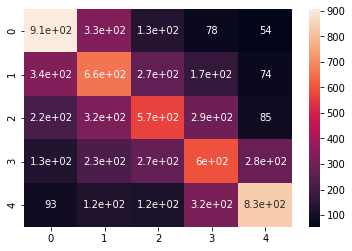

In [176]:
predtest2 = model2.predict_classes(test_sequences2)
sns.heatmap(confusion_matrix(testy2,predtest2),annot=True)

------------

In [177]:
model4.evaluate(test_sequences2,testy2)

7500/7500 [==============================] - 3s 389us/sample - loss: 2.1445 - acc: 0.4903


[2.1445190687179565, 0.49026668]

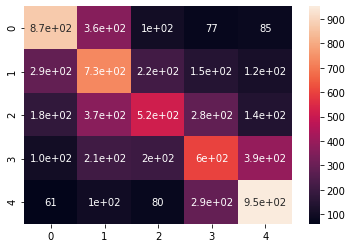

In [180]:
predtest4 = model4.predict_classes(test_sequences2)
sns.heatmap(confusion_matrix(testy2,predtest4),annot=True)